In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'HUN'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,2755,-2305,450,69,277,1691,1911,4228,130,...,1185,0,270,2215,3626,7211,-67,-107,246.0,2014-05-02
1,2014-06-30,2988,-2483,505,124,403,1819,1847,4448,130,...,1162,0,257,2144,3814,7300,50,-107,246.0,2014-08-01
2,2014-09-30,2884,-2369,515,194,582,1639,1788,4494,126,...,1176,0,274,2122,3758,7190,360,-137,246.0,2014-11-01
3,2014-12-31,2951,-2502,449,-34,860,1665,2025,5039,122,...,1275,0,267,2332,4860,9168,417,-250,246.0,2015-02-21
4,2015-03-31,2589,-2139,450,17,994,1633,1869,4887,119,...,1191,0,529,2474,4835,9184,34,-149,245.0,2015-05-02


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-03-31,2023-05-02,177.0,1606,-1337,269,44,615,878,1048,...,415,7763,857,0,11,1297,1509,4023,-154,-46
37,2023-06-30,2023-08-01,177.0,1596,-1342,254,33,502,856,1012,...,406,7553,745,0,11,1176,1562,3969,36,-51
38,2023-09-30,2023-11-01,177.0,1506,-1275,231,15,496,822,941,...,395,7369,726,0,113,1271,1493,3970,163,-50
39,2023-12-31,2024-02-21,177.0,1403,-1251,152,-57,540,747,867,...,387,7248,719,0,12,1172,1676,4025,164,-83
40,2024-03-31,2024-04-29,171.8,1470,-1269,201,-16,552,837,896,...,378,7577,745,0,396,1574,1660,4174,-62,-42


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-02,177.0,1606,-1337,269,44,615,878,1048,...,7763,857,0,11,1297,1509,4023,-154,-46,1
37,2023-06-30,2023-08-01,177.0,1596,-1342,254,33,502,856,1012,...,7553,745,0,11,1176,1562,3969,36,-51,1
38,2023-09-30,2023-11-01,177.0,1506,-1275,231,15,496,822,941,...,7369,726,0,113,1271,1493,3970,163,-50,1
39,2023-12-31,2024-02-21,177.0,1403,-1251,152,-57,540,747,867,...,7248,719,0,12,1172,1676,4025,164,-83,1
40,2024-03-31,2024-04-29,171.8,1470,-1269,201,-16,552,837,896,...,7577,745,0,396,1574,1660,4174,-62,-42,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-05-02,177.0,1606.0,-1337.0,269.0,44.0,615.0,878.0,1048.0,...,7763.0,857.0,0.0,11.0,1297.0,1509.0,4023.0,-154.0,-46.0,1
37,2023-06-30,2023-08-01,177.0,1596.0,-1342.0,254.0,33.0,502.0,856.0,1012.0,...,7553.0,745.0,0.0,11.0,1176.0,1562.0,3969.0,36.0,-51.0,1
38,2023-09-30,2023-11-01,177.0,1506.0,-1275.0,231.0,15.0,496.0,822.0,941.0,...,7369.0,726.0,0.0,113.0,1271.0,1493.0,3970.0,163.0,-50.0,1
39,2023-12-31,2024-02-21,177.0,1403.0,-1251.0,152.0,-57.0,540.0,747.0,867.0,...,7248.0,719.0,0.0,12.0,1172.0,1676.0,4025.0,164.0,-83.0,1
40,2024-03-31,2024-04-29,171.8,1470.0,-1269.0,201.0,-16.0,552.0,837.0,896.0,...,7577.0,745.0,0.0,396.0,1574.0,1660.0,4174.0,-62.0,-42.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-05-05,18.936525,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.218489,0.781511,0.0,0.0,0.0,0.0,0.163339,0.025045,0.0,0.0
1,2014-05-12,18.966637,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.218489,0.781511,0.0,0.0,0.0,0.0,0.163339,0.025045,0.0,0.0
2,2014-05-19,20.231075,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.218489,0.781511,0.0,0.0,0.0,0.0,0.163339,0.025045,0.0,0.0
3,2014-05-26,20.088081,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.218489,0.781511,0.0,0.0,0.0,0.0,0.163339,0.025045,0.0,0.0
4,2014-06-02,21.615944,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.218489,0.781511,0.0,0.0,0.0,0.0,0.163339,0.025045,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-05-05,18.936525,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.0,0.163339,0.025045,0.0,0.0,inf,2.310707,0.422721,1.051941,inf
1,2014-05-12,18.966637,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.0,0.163339,0.025045,0.0,0.0,inf,2.314381,0.423393,1.052613,inf
2,2014-05-19,20.231075,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.0,0.163339,0.025045,0.0,0.0,inf,2.468673,0.451619,1.080839,inf
3,2014-05-26,20.088081,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.0,0.163339,0.025045,0.0,0.0,inf,2.451224,0.448427,1.077647,inf
4,2014-06-02,21.615944,2014-03-31,2755.0,0.0,8.195122,246.0,0.0,0.0,277.0,...,0.0,0.163339,0.025045,0.0,0.0,inf,2.637660,0.482534,1.111753,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

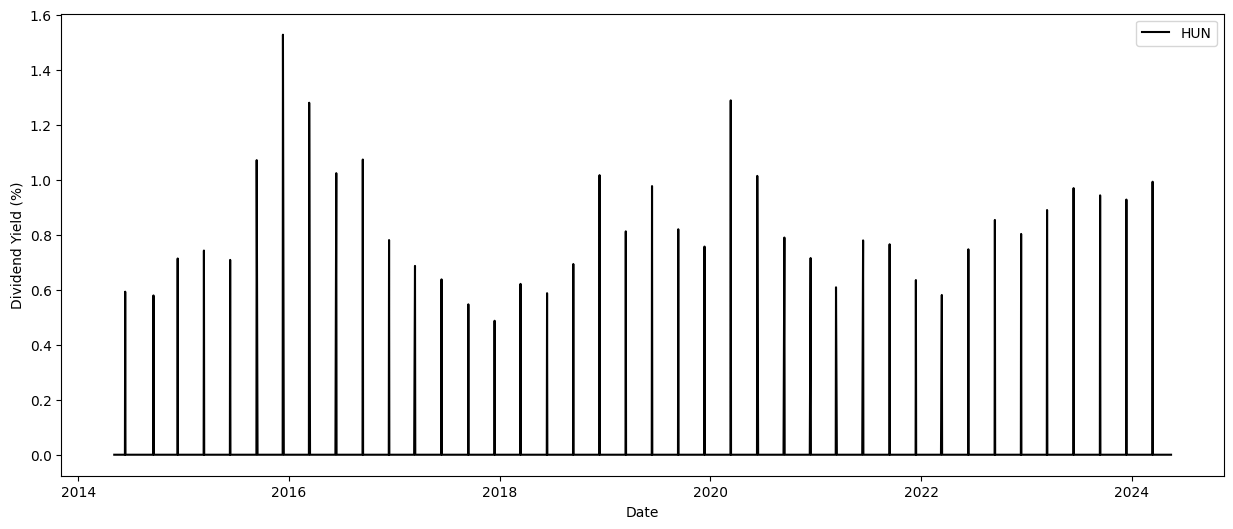

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


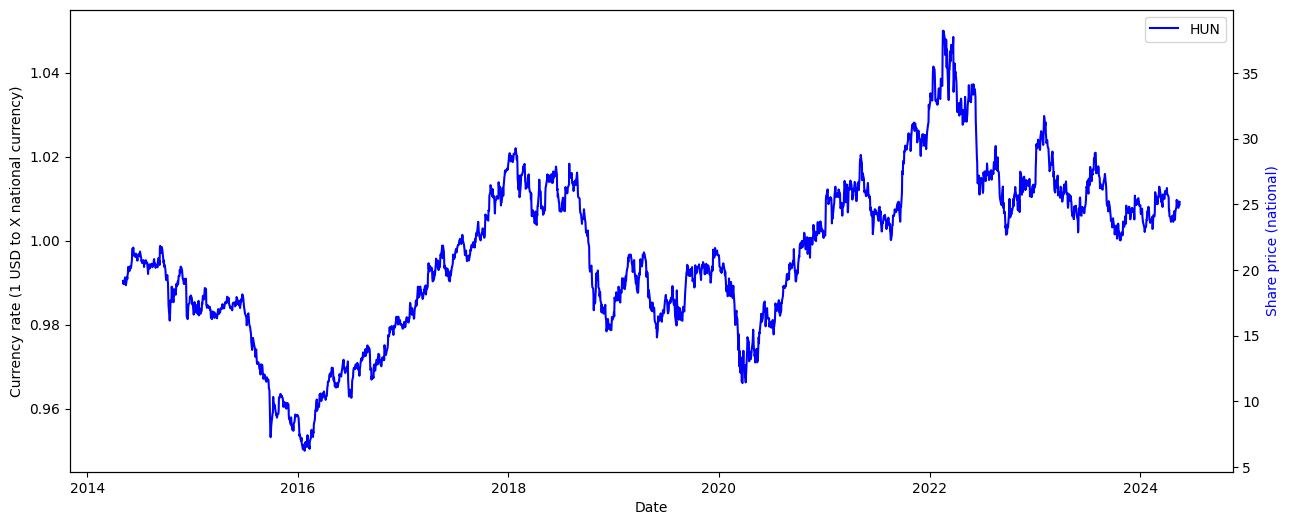

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

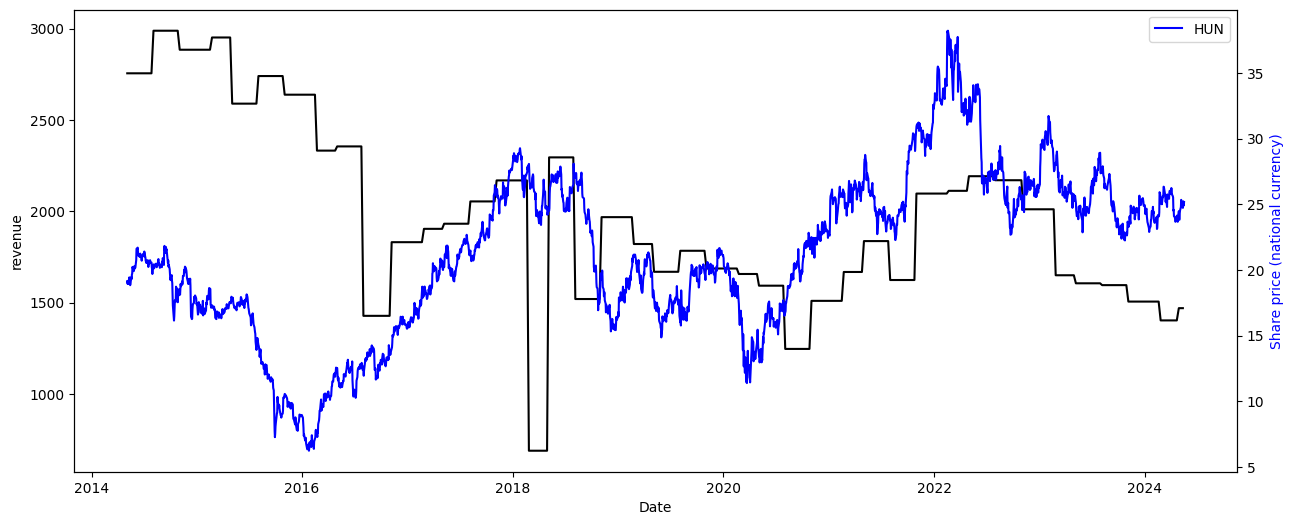

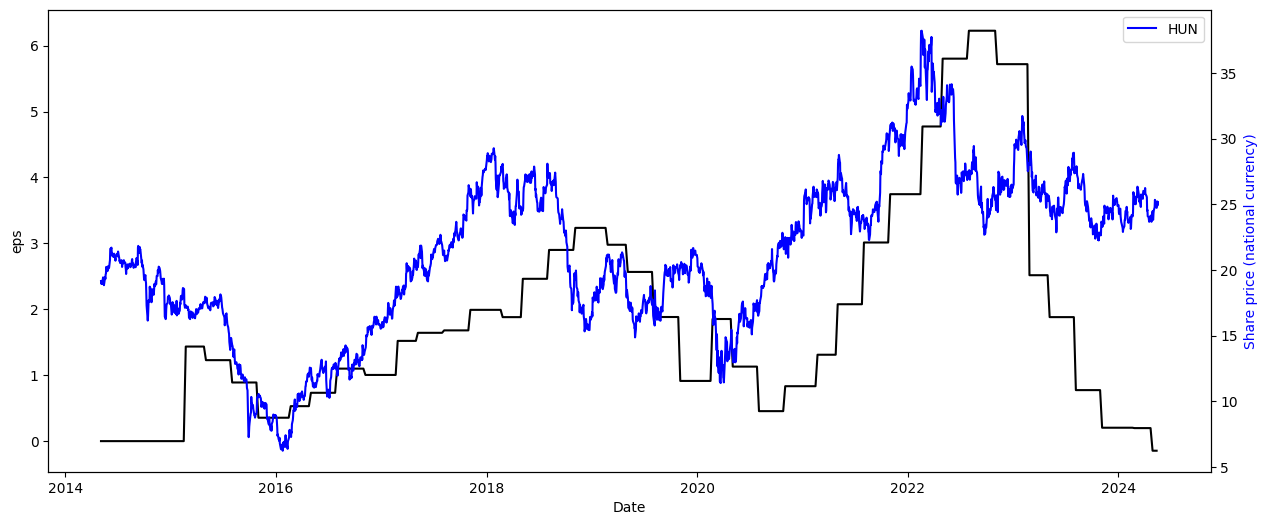

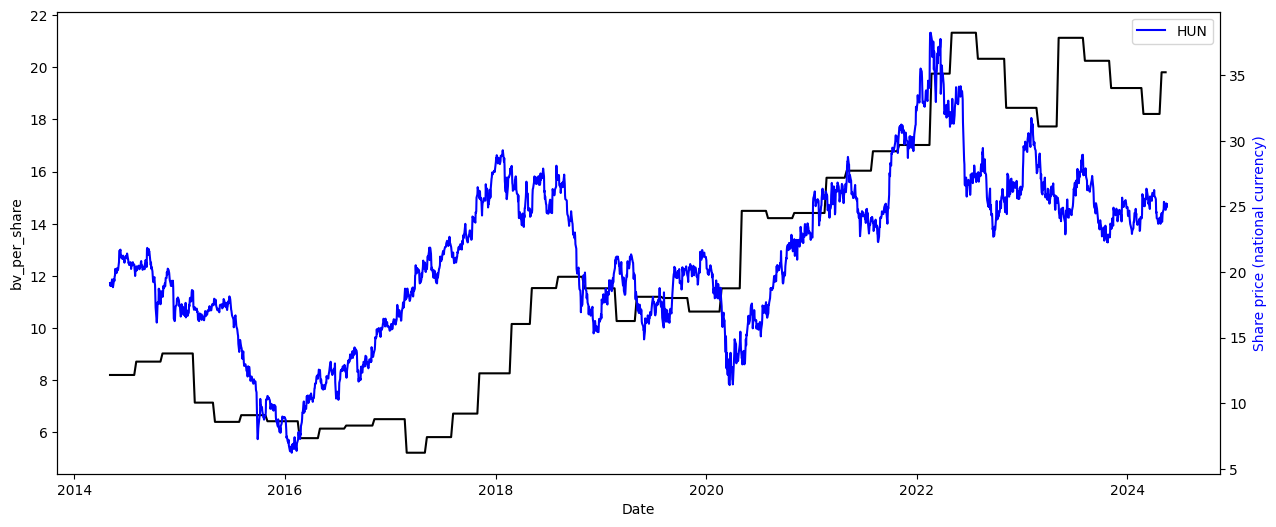

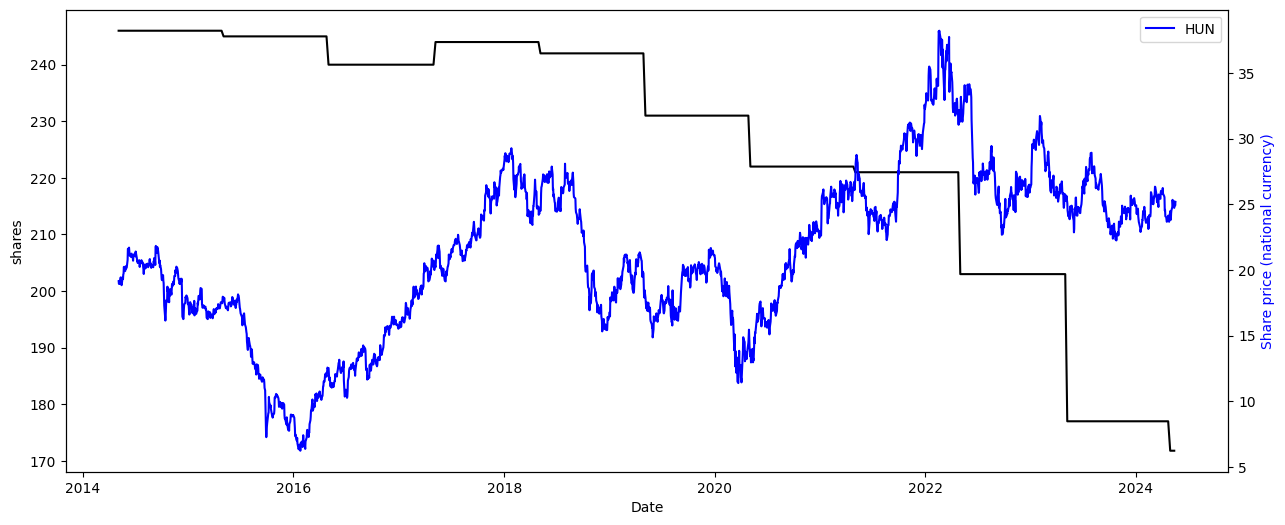

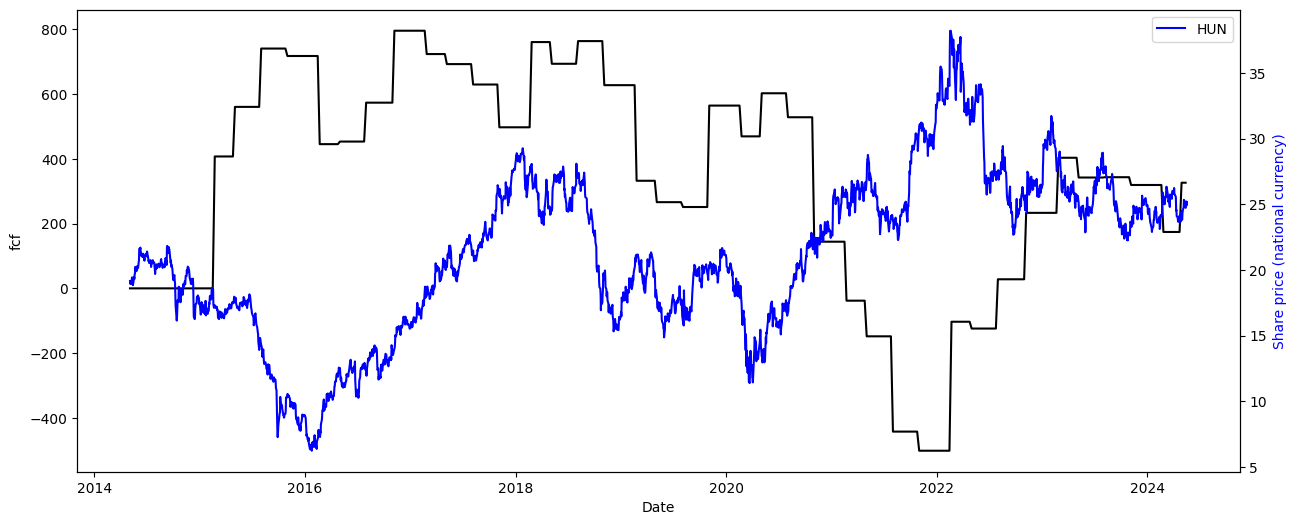

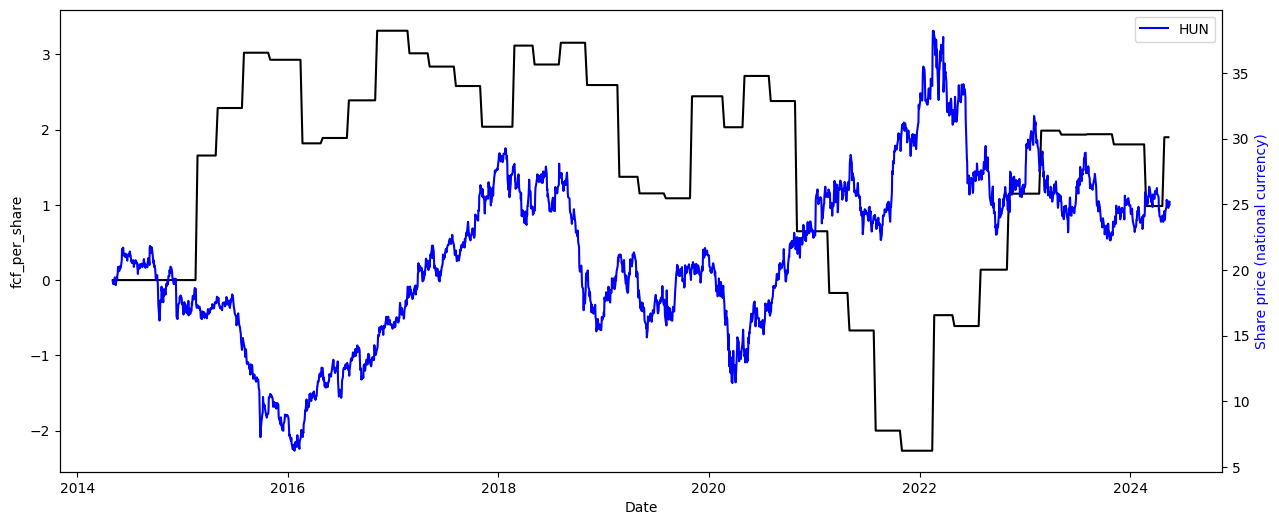

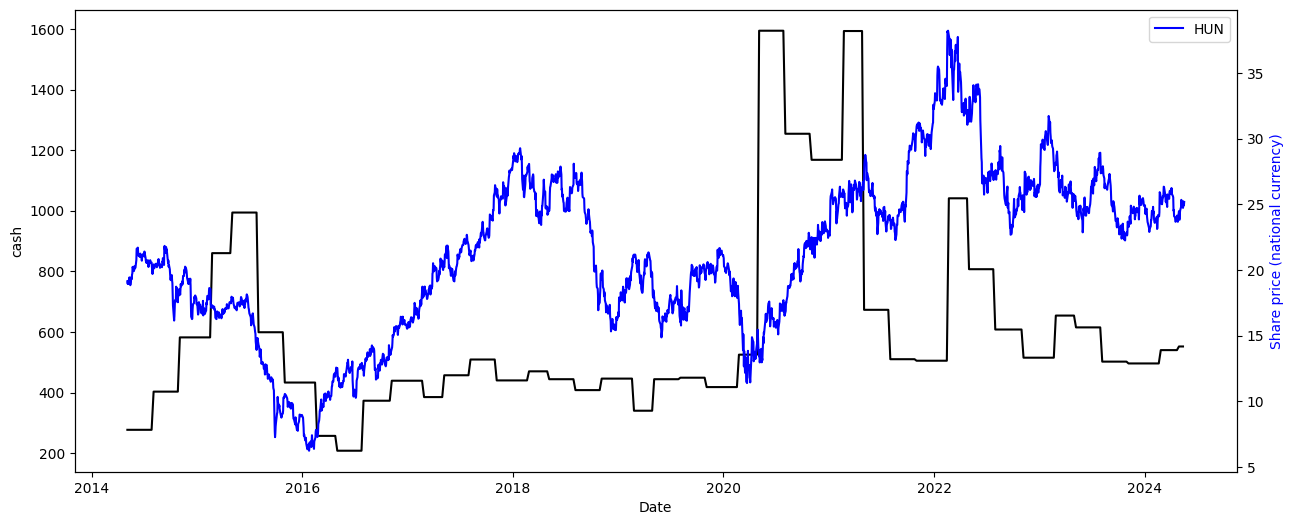

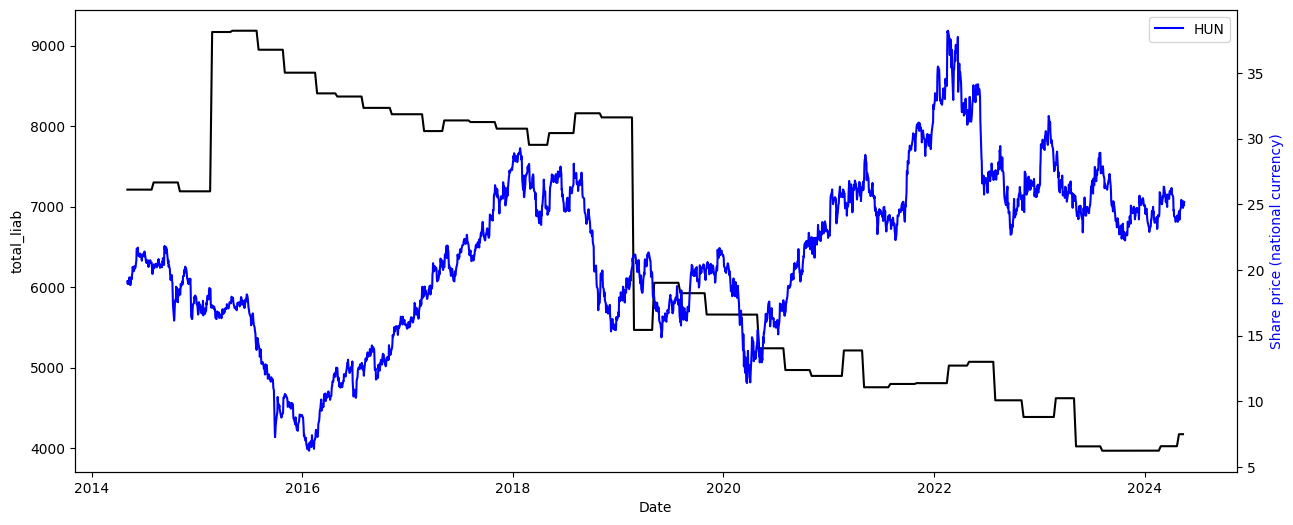

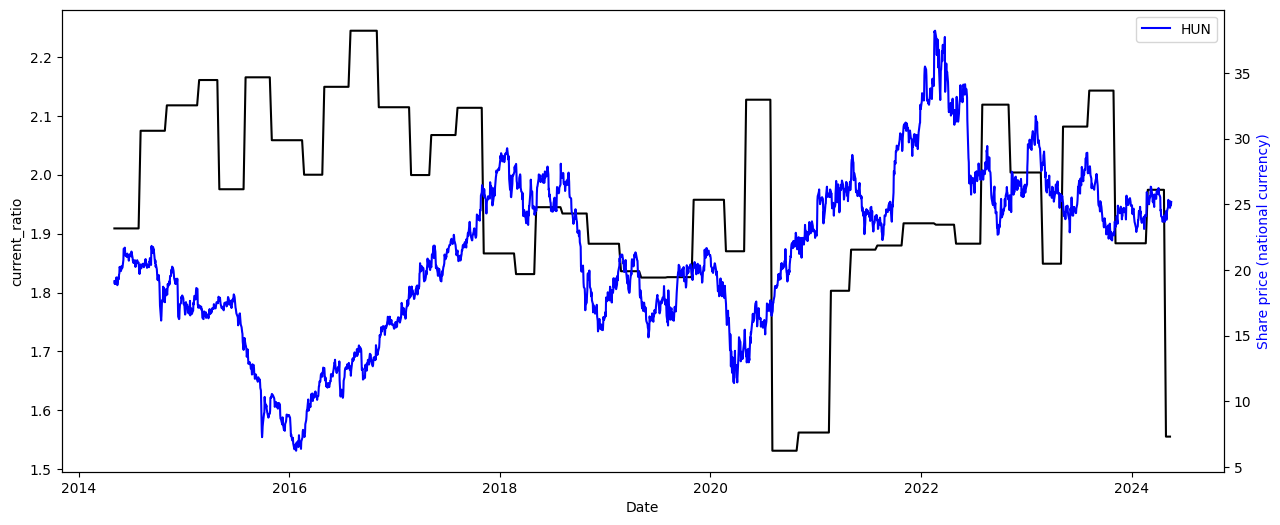

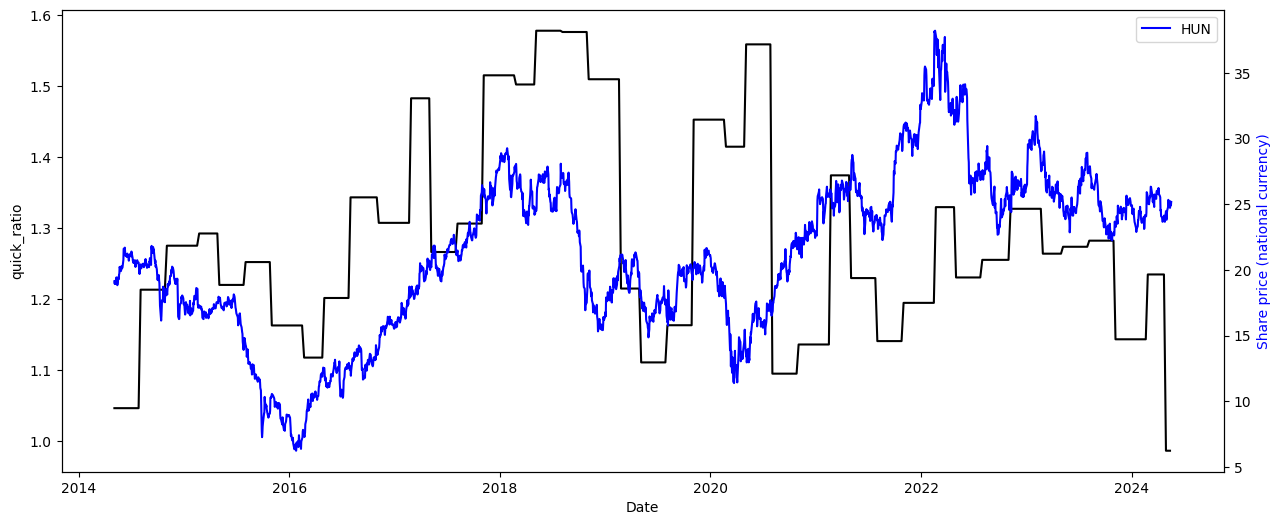

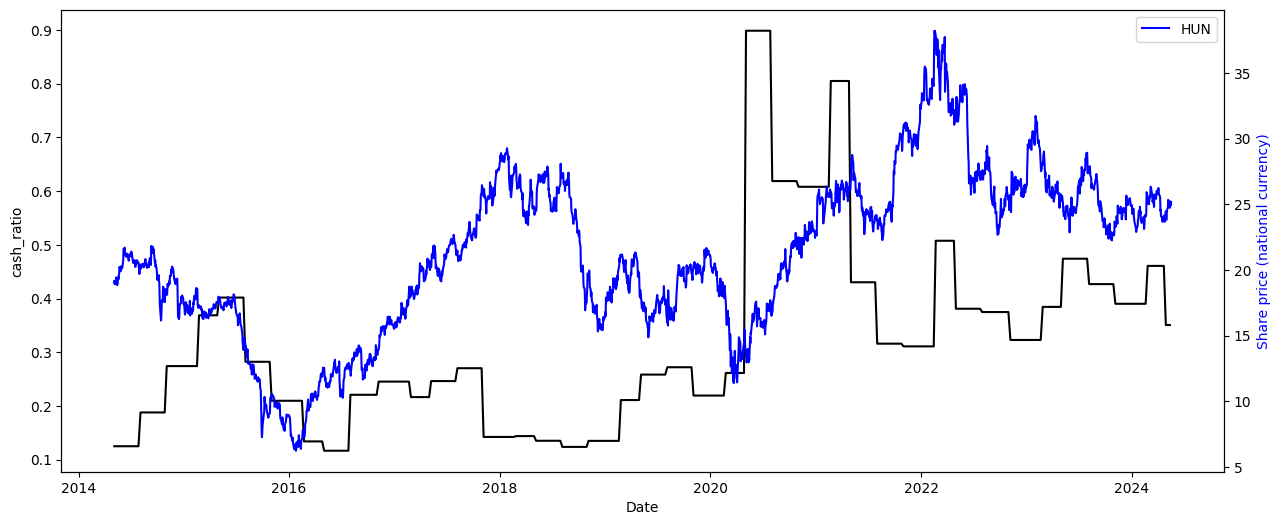

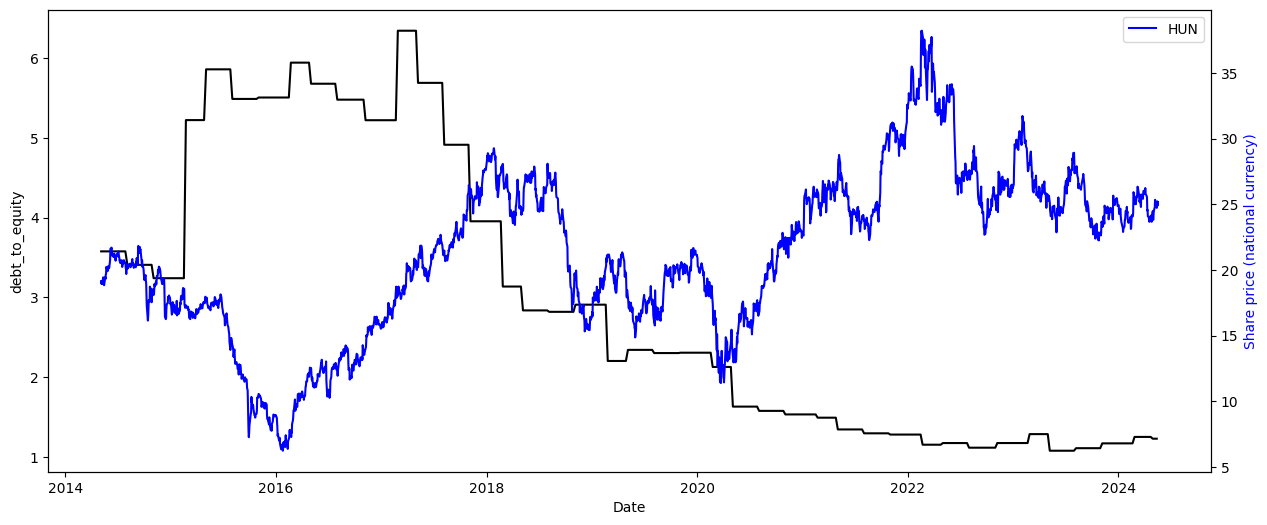

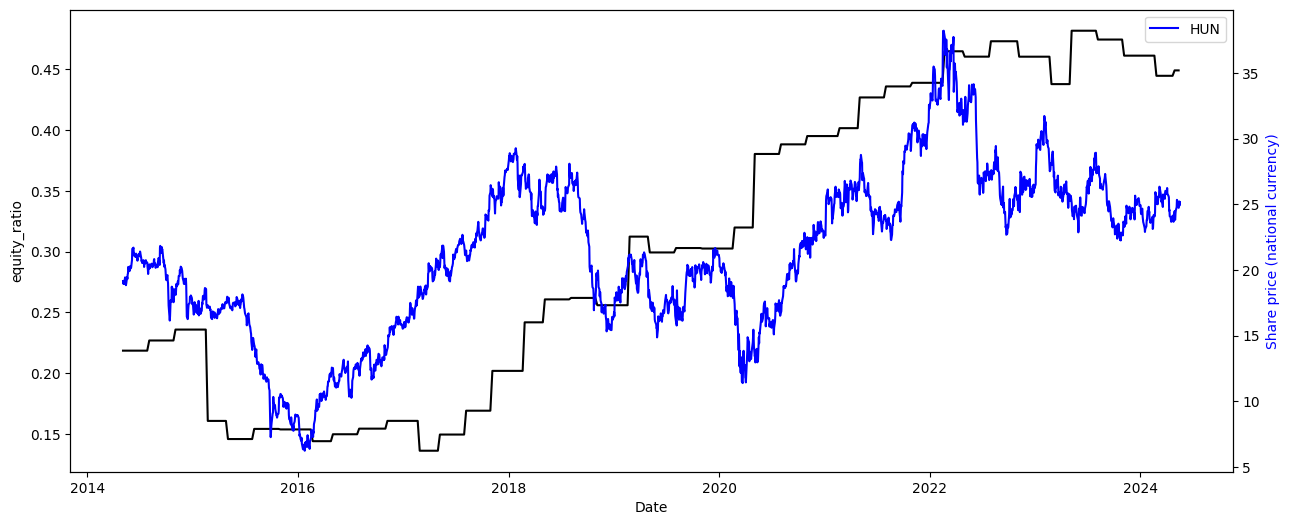

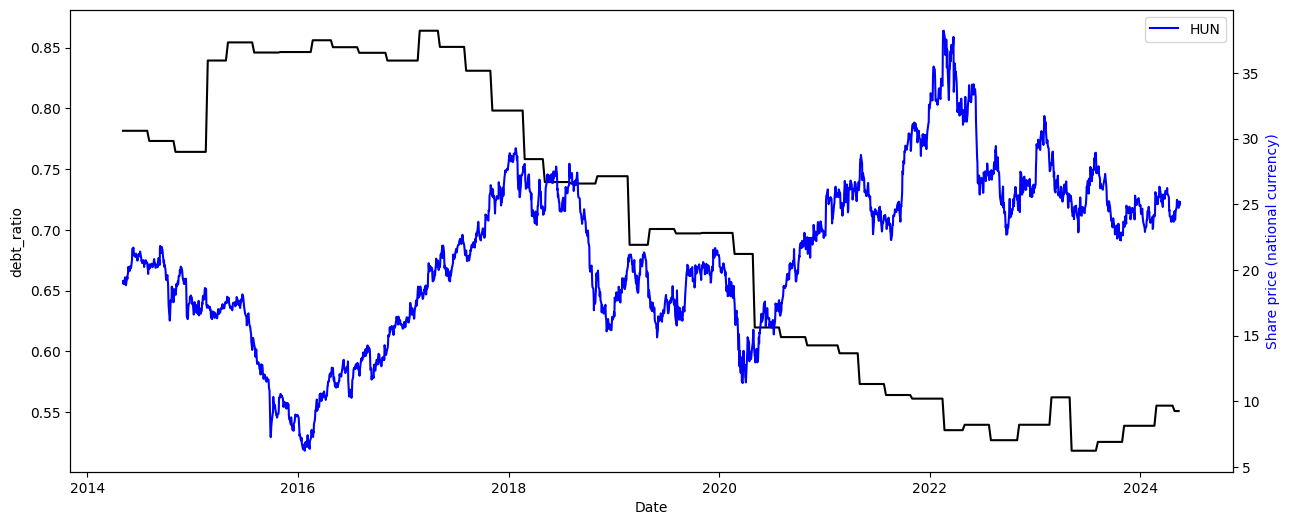

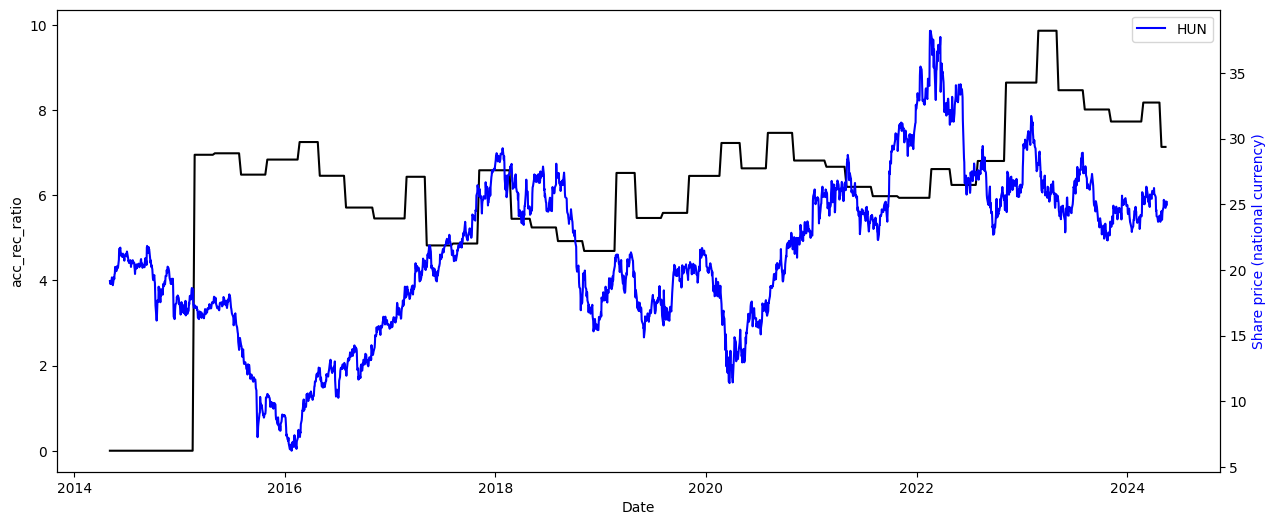

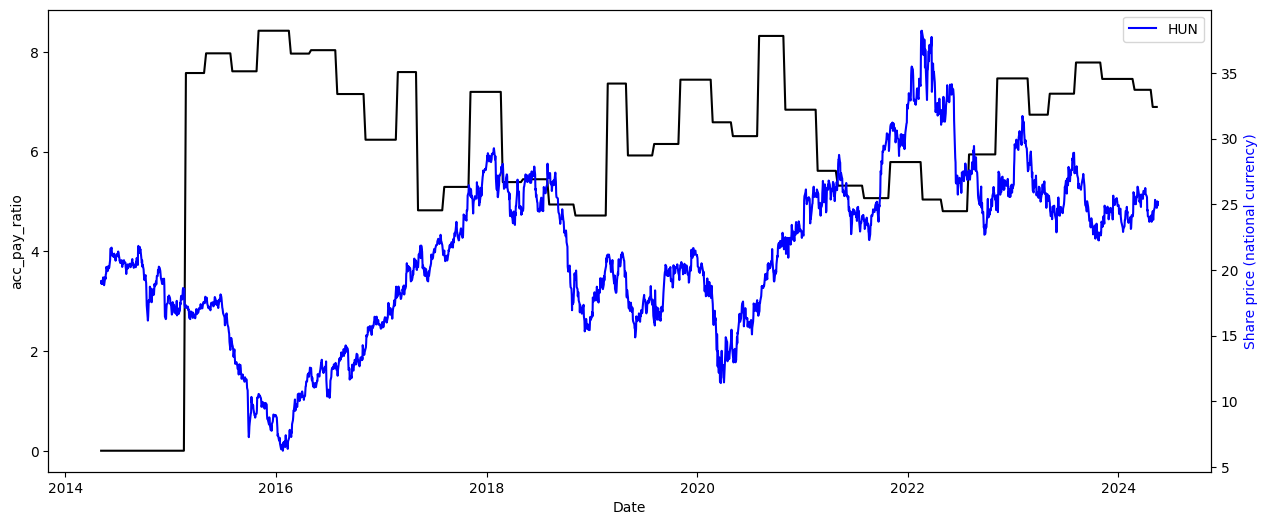

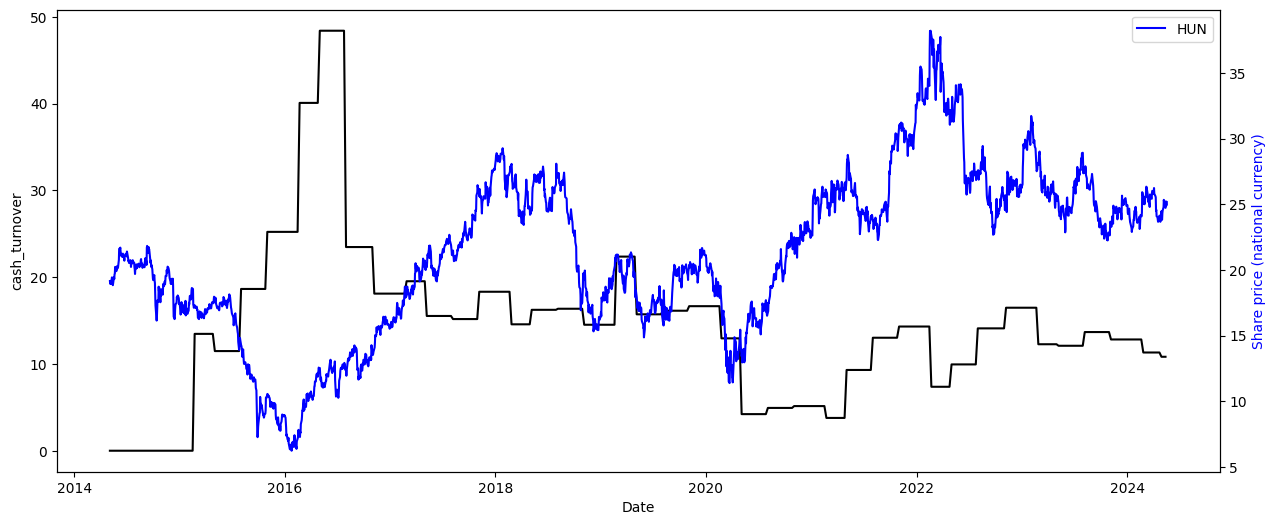

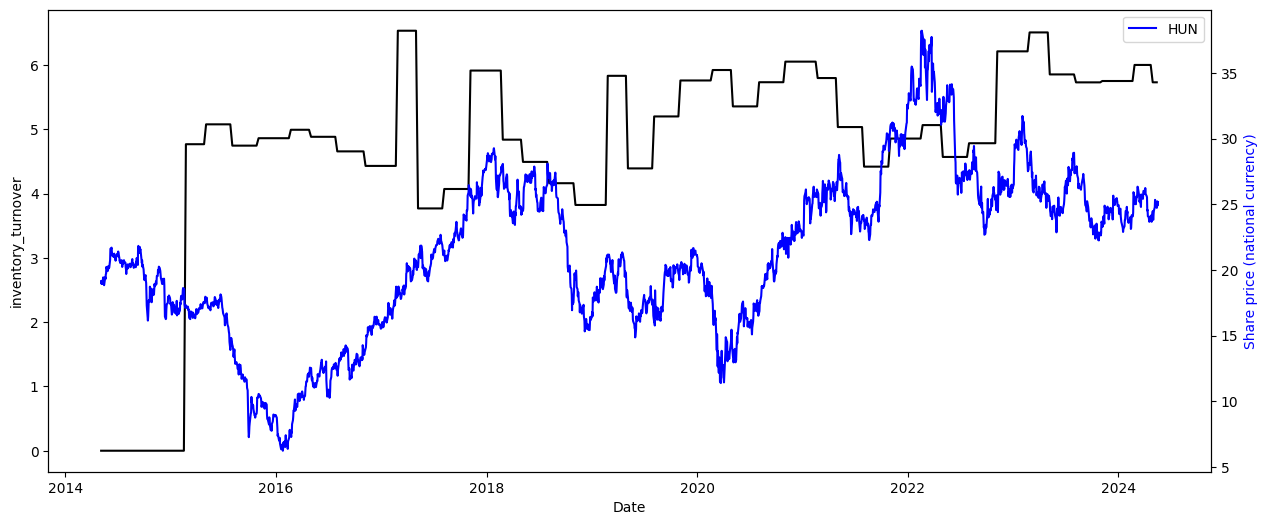

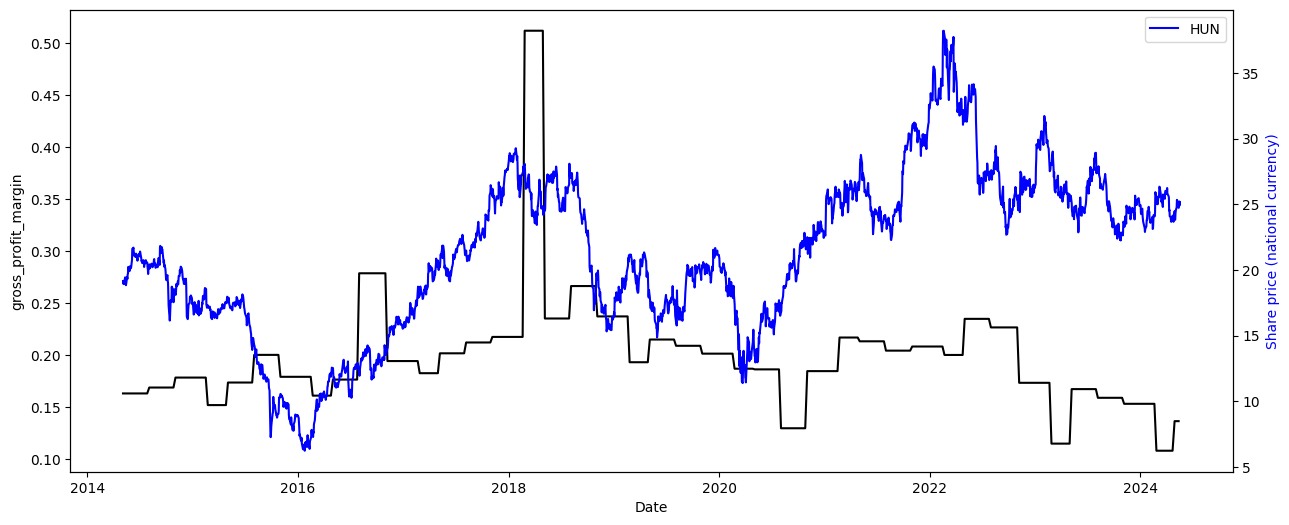

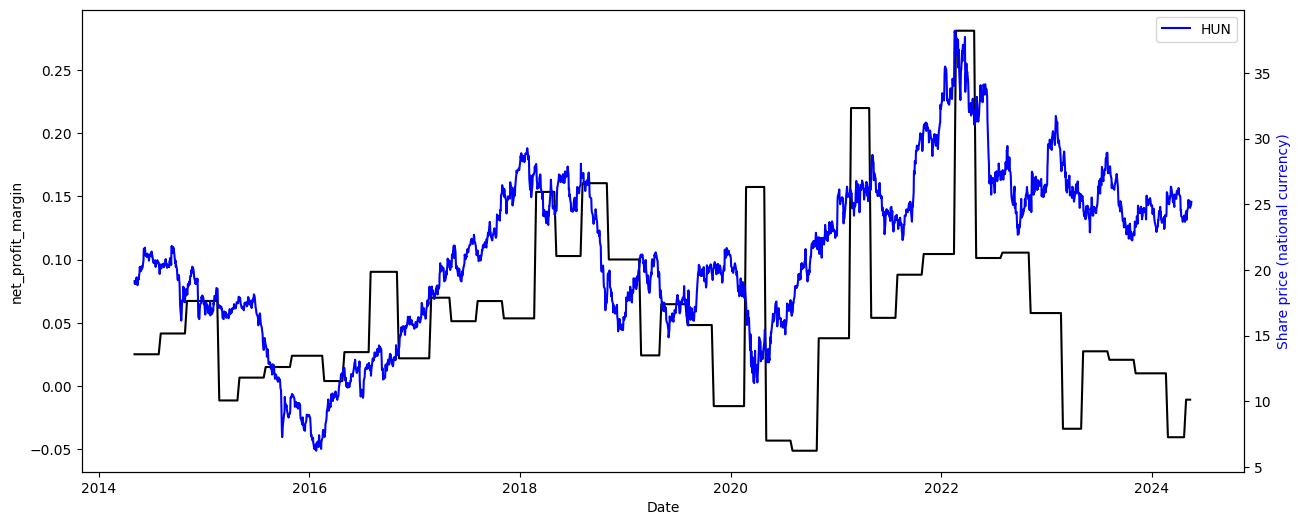

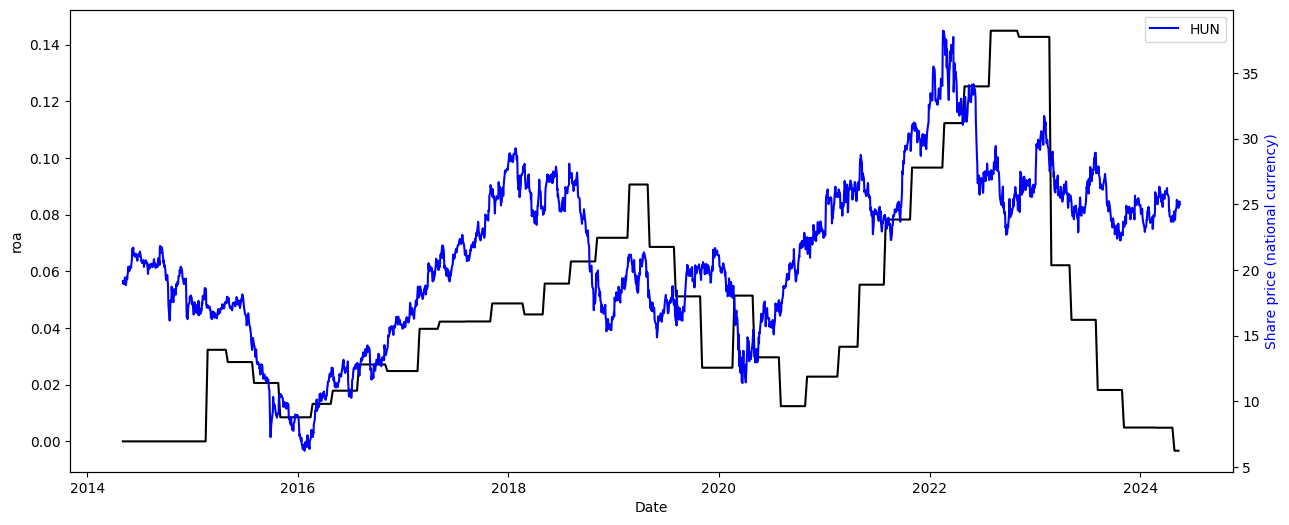

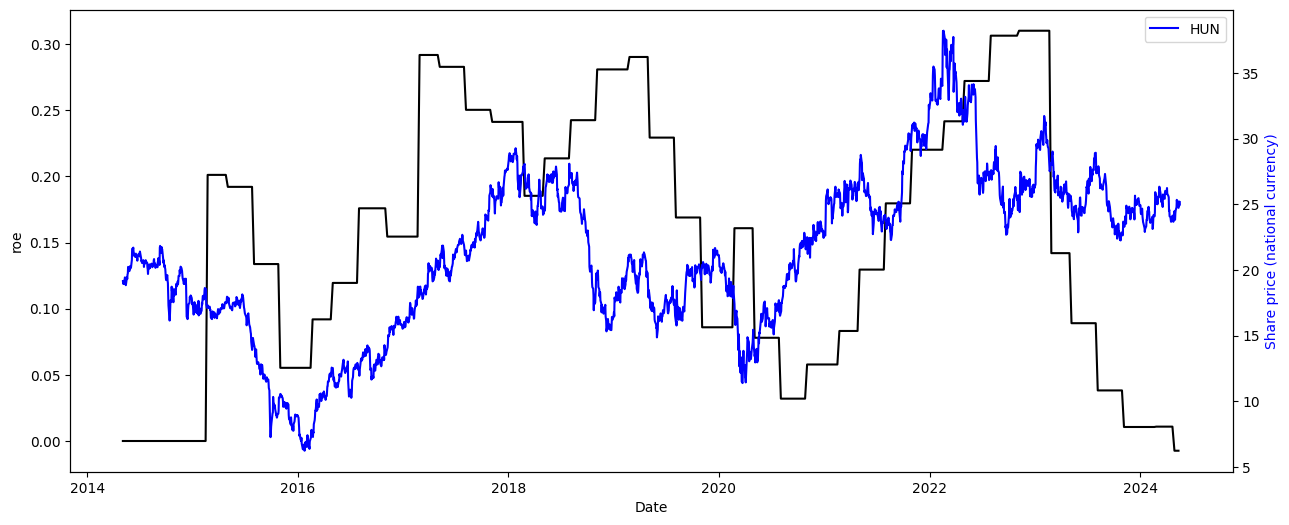

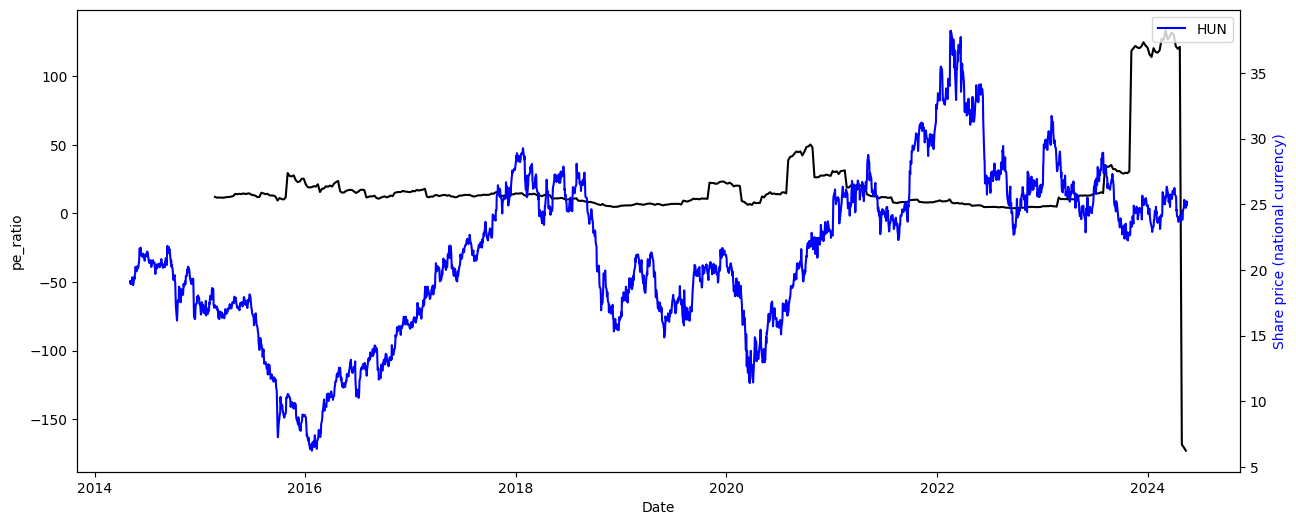

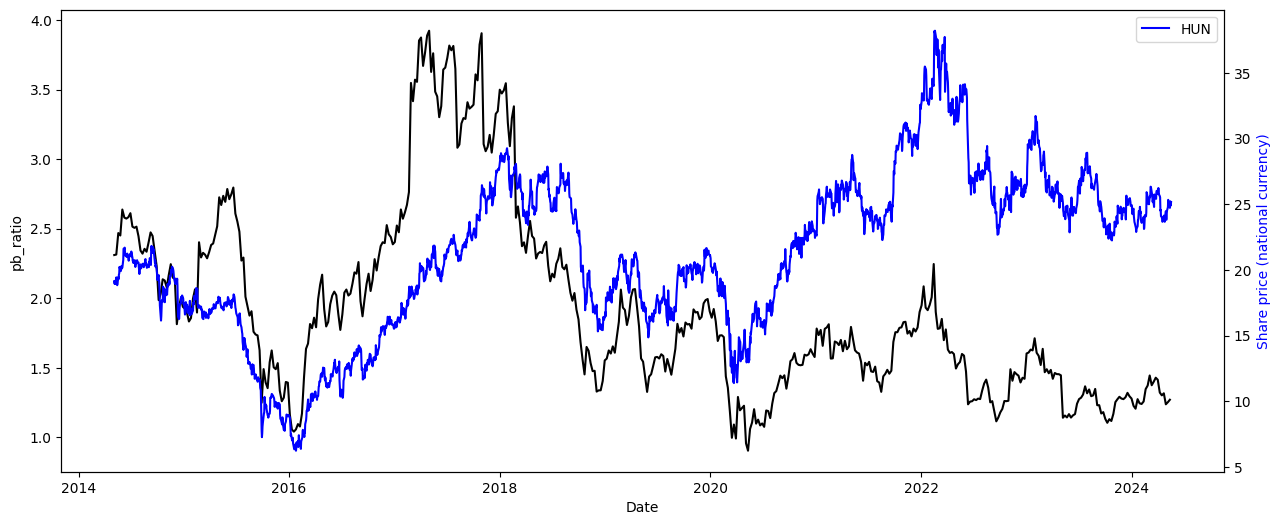

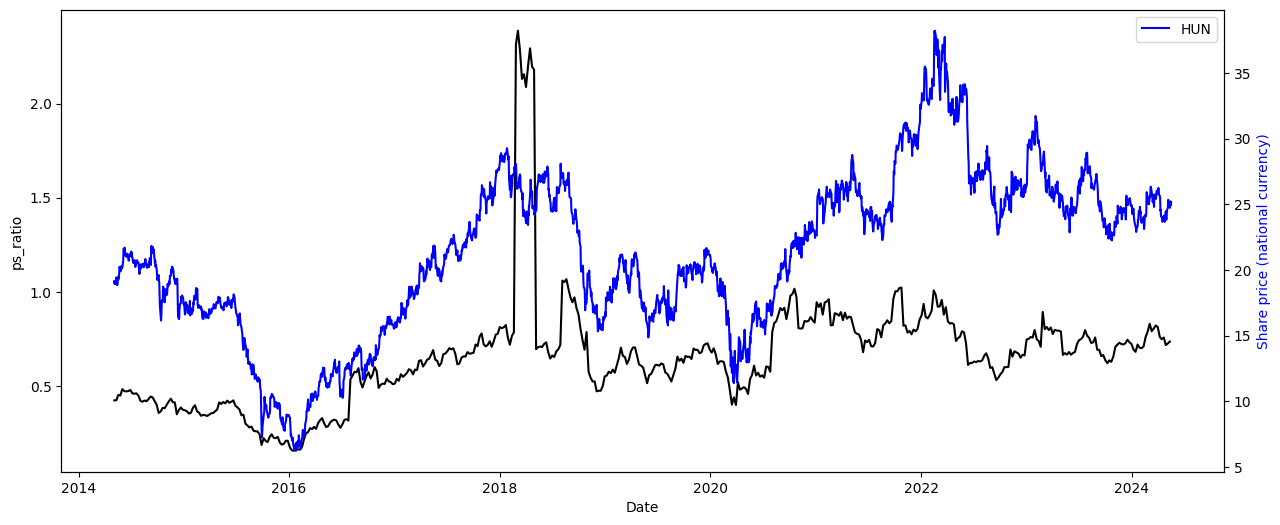

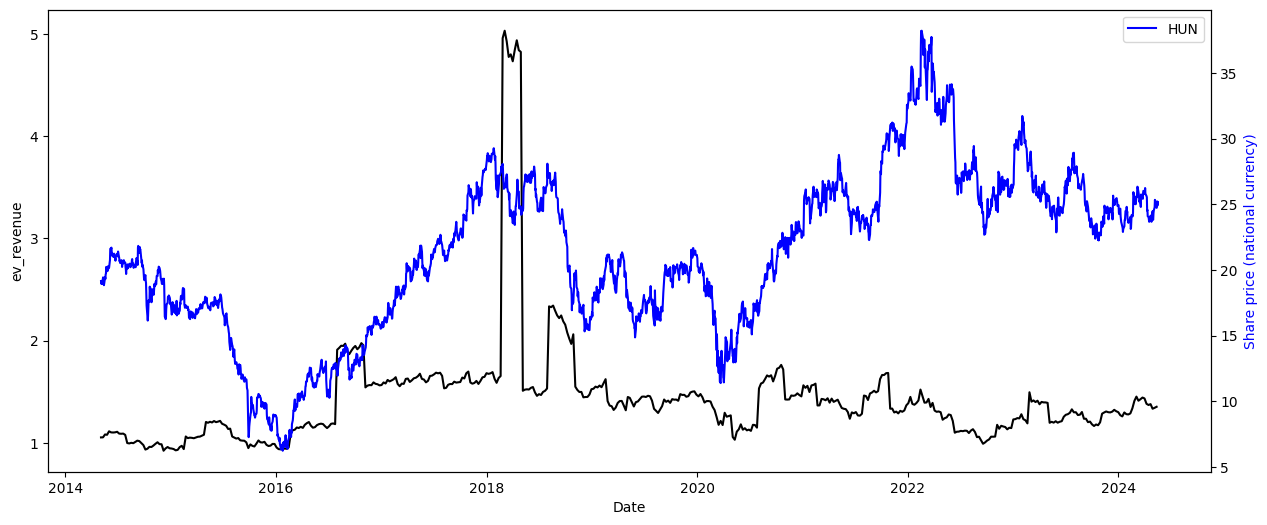

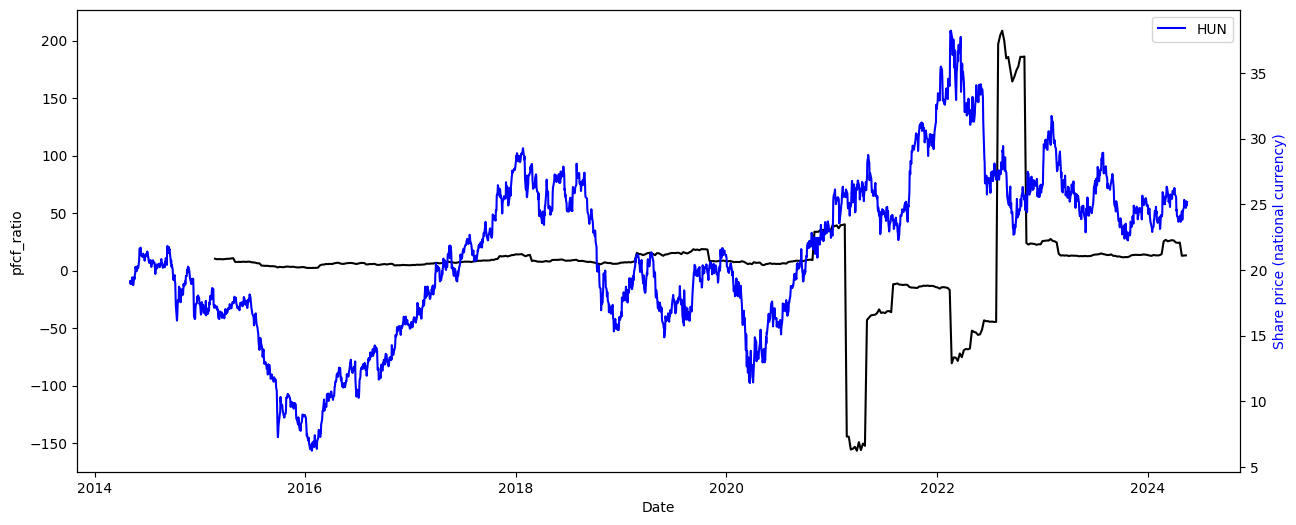

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

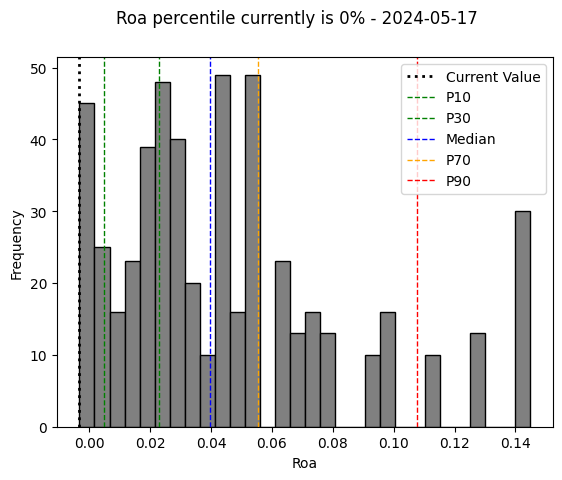

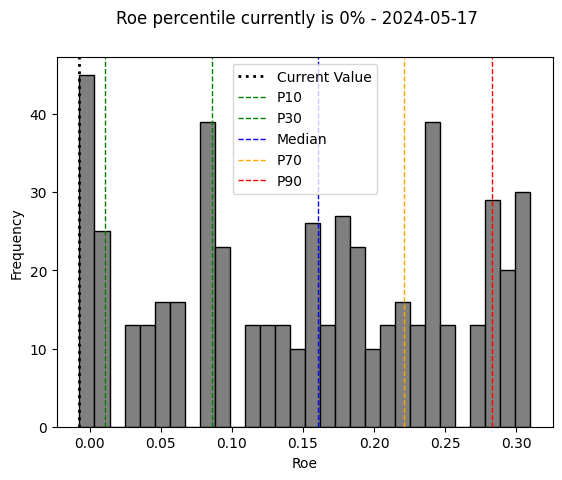

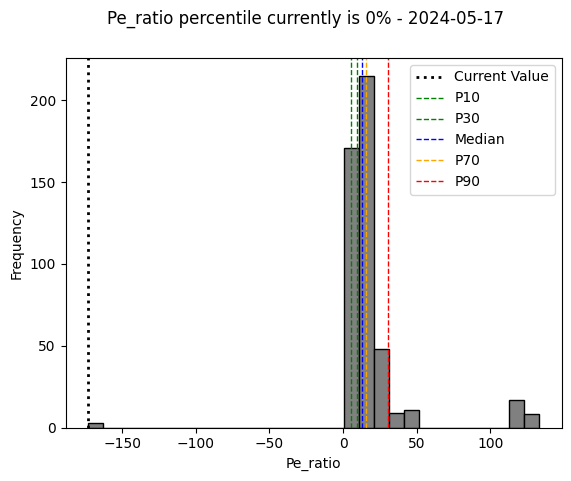

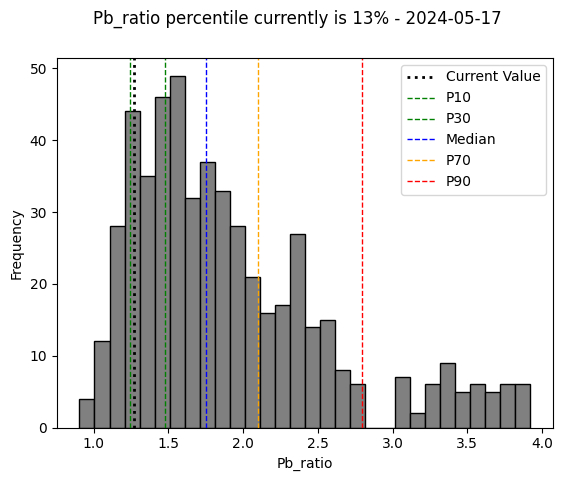

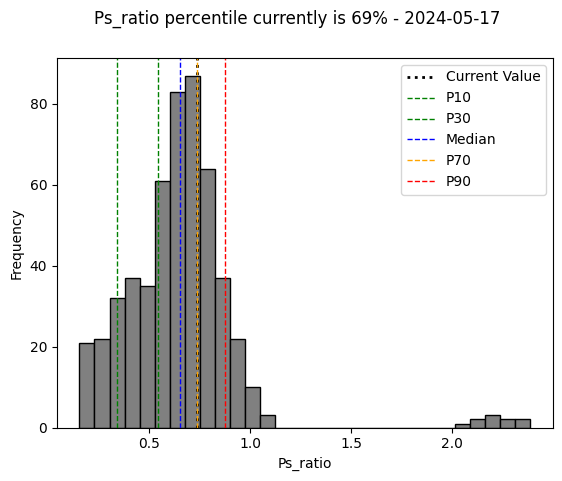

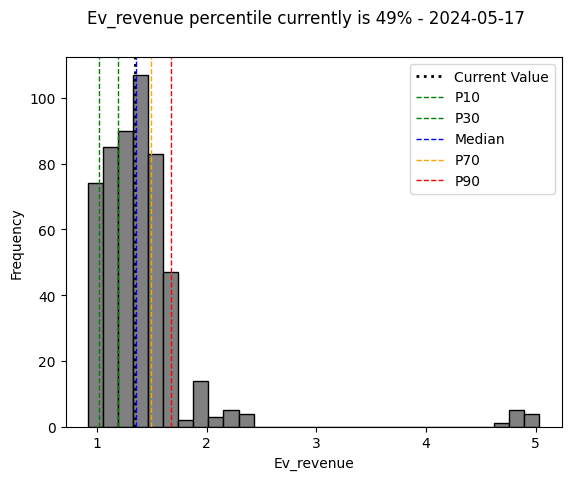

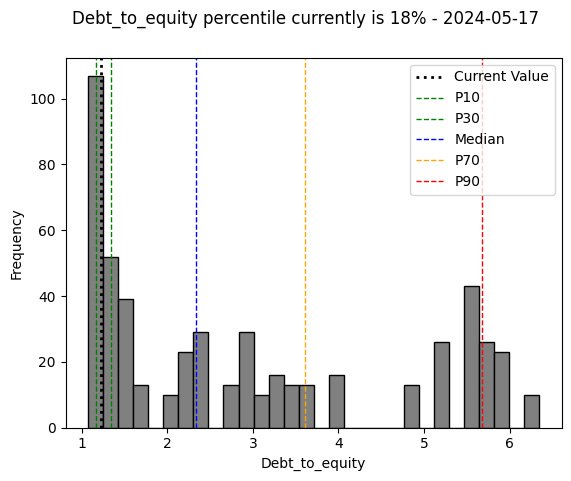

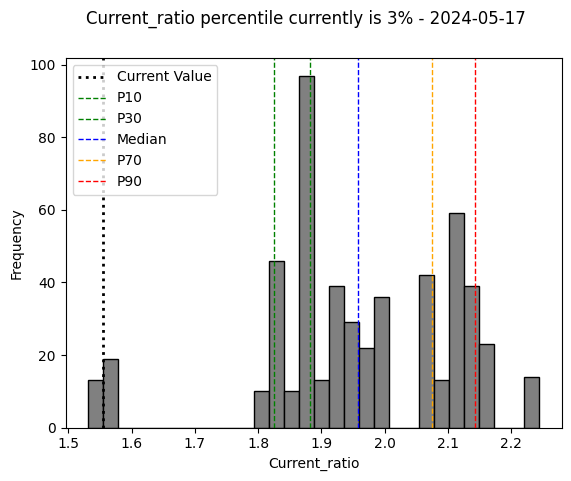

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.798868,-0.356077,-0.150685,0.244766,0.033843,-0.424044,-0.080385
roe,0.798868,1.000000,-0.451150,0.321744,0.158806,0.204663,0.092134,0.069178
pe_ratio,-0.356077,-0.451150,1.000000,-0.136120,0.051144,-0.029199,-0.129425,-0.023829
pb_ratio,-0.150685,0.321744,-0.136120,1.000000,0.073057,0.272506,0.637005,0.168623
ps_ratio,0.244766,0.158806,0.051144,0.073057,1.000000,0.850294,-0.429566,-0.459161
ev_revenue,0.033843,0.204663,-0.029199,0.272506,0.850294,1.000000,0.031304,-0.224895
debt_to_equity,-0.424044,0.092134,-0.129425,0.637005,-0.429566,0.031304,1.000000,0.475209
current_ratio,-0.080385,0.069178,-0.023829,0.168623,-0.459161,-0.224895,0.475209,1.000000


0 timestemos have been found!


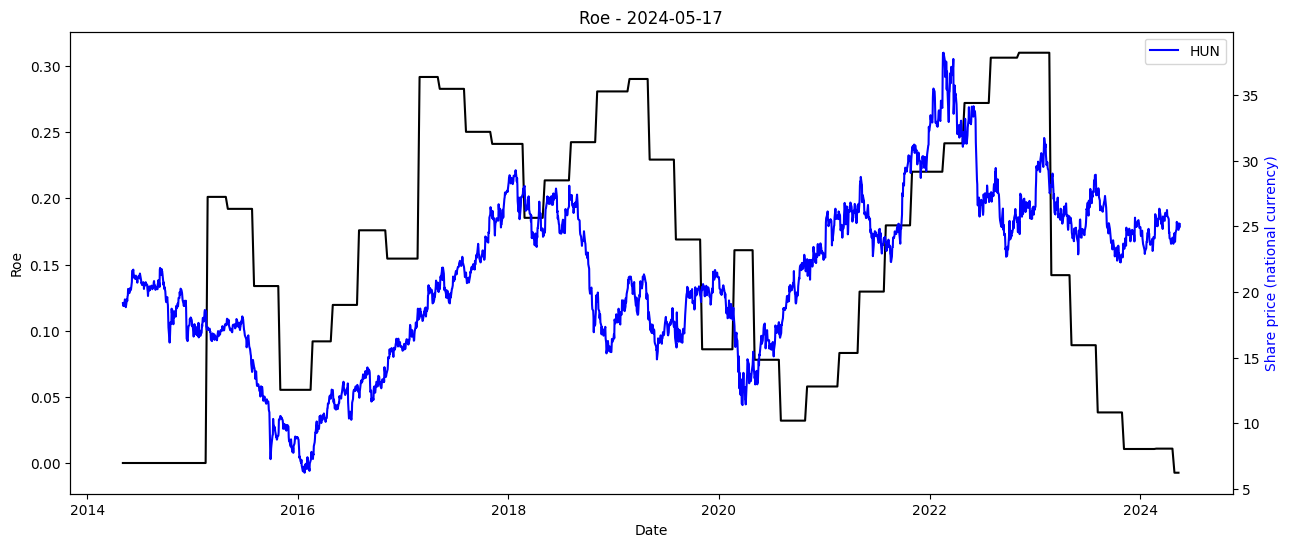

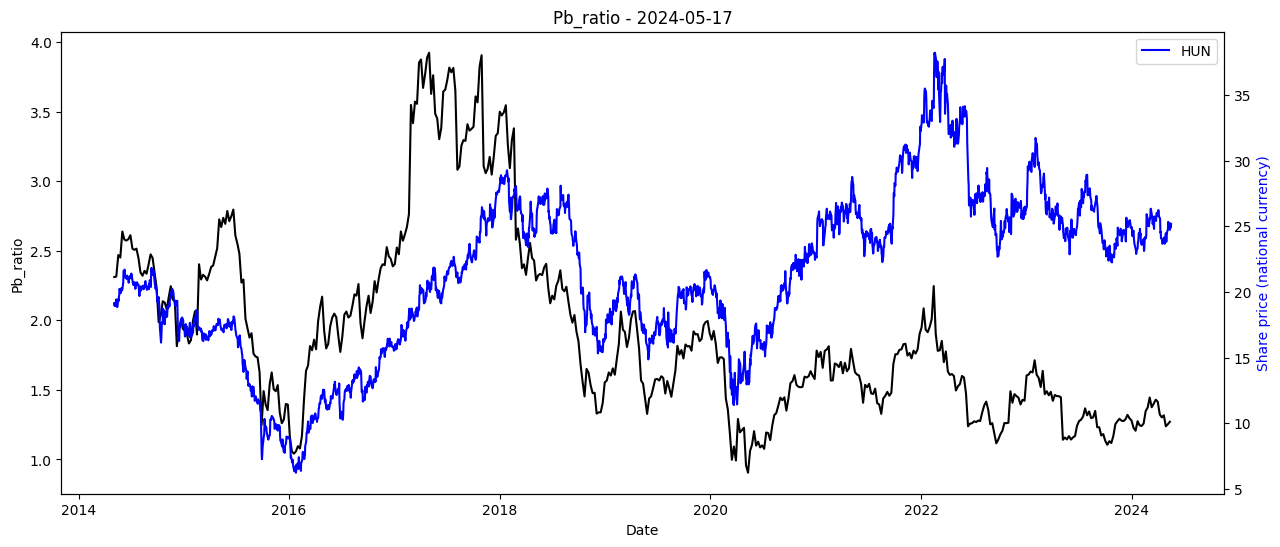

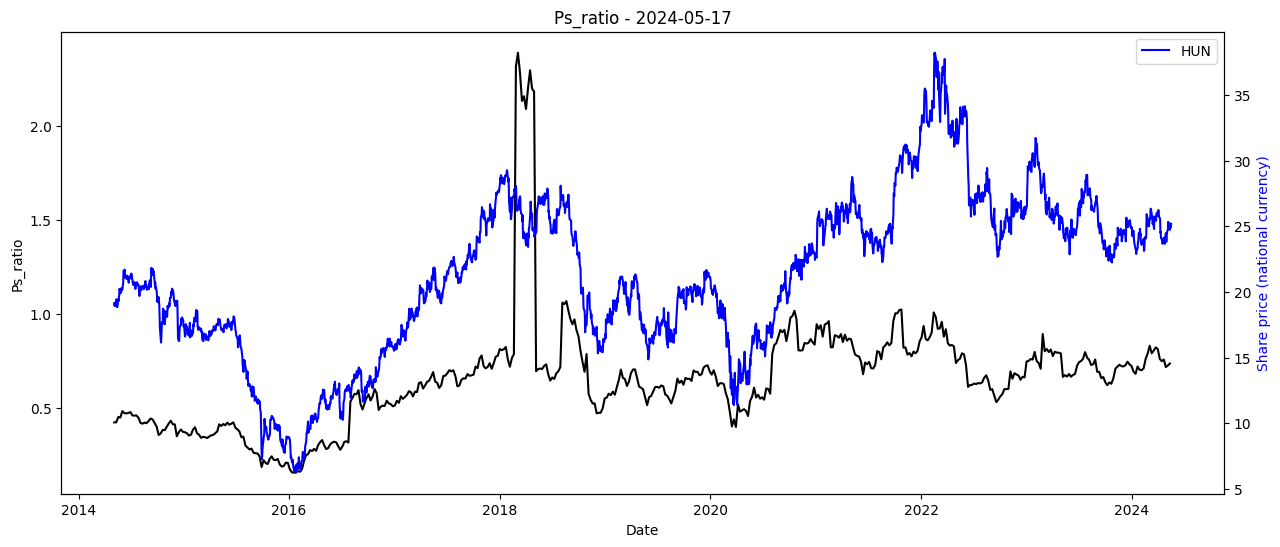

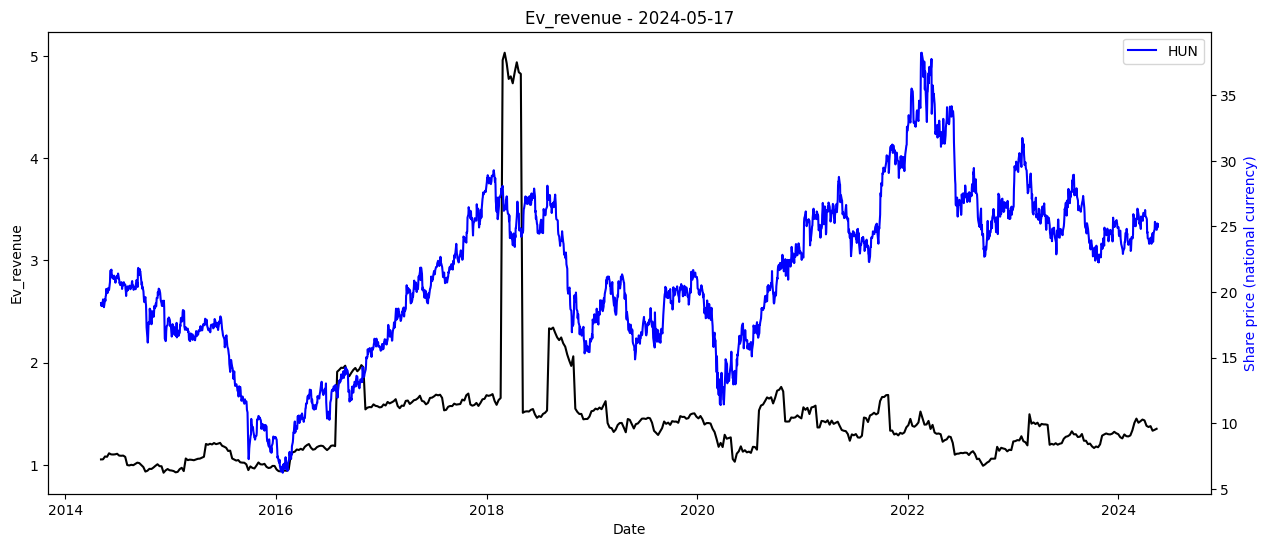

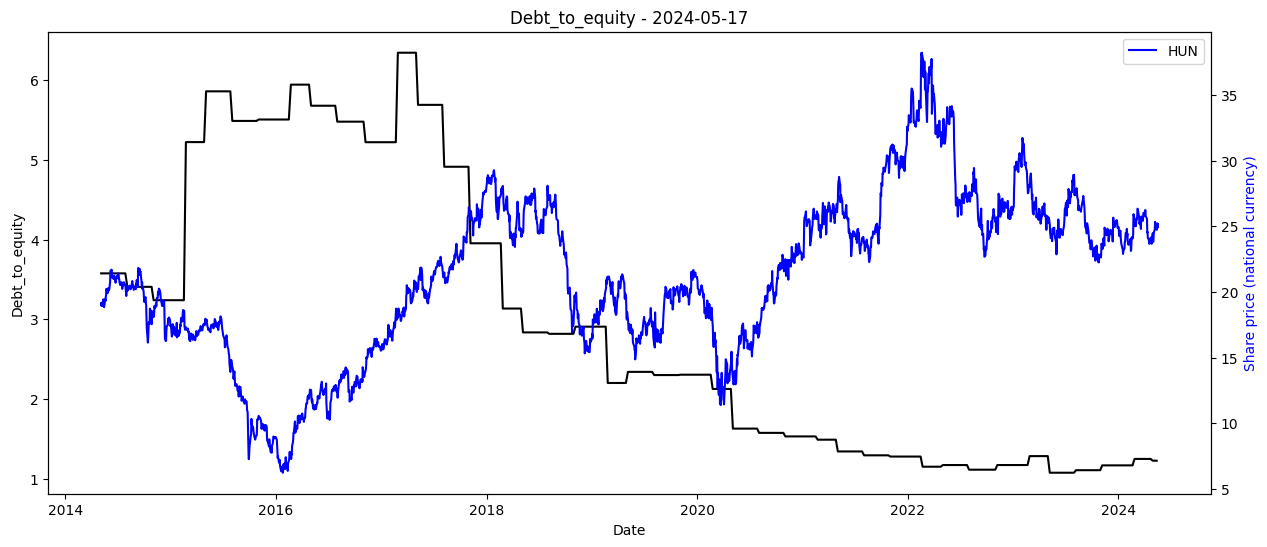

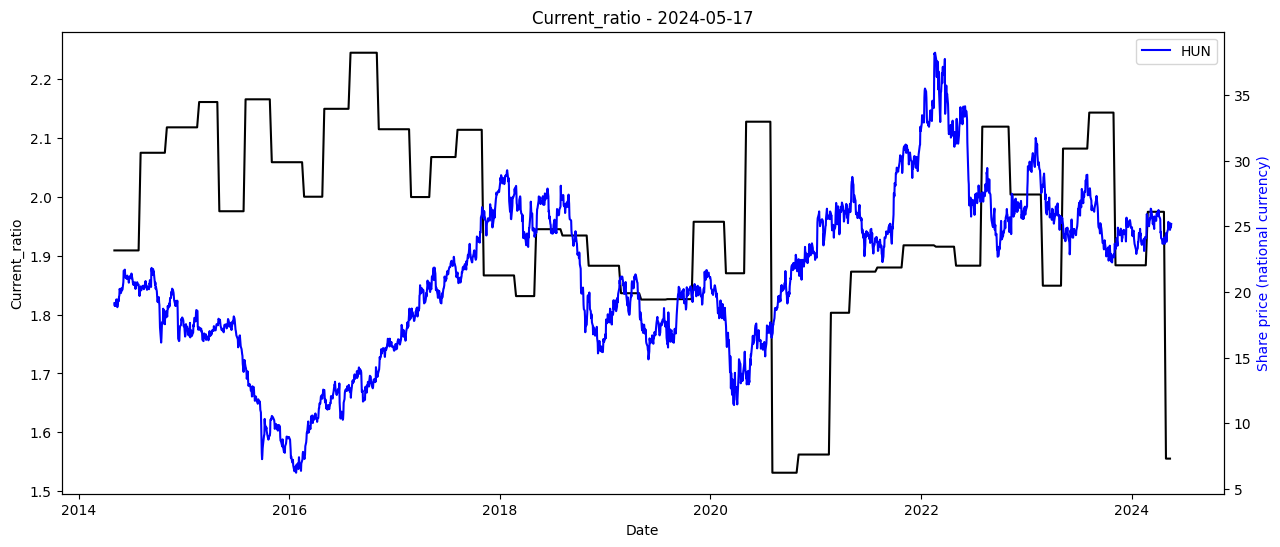

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )